In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dropout, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix, classification_report
import itertools

## Exploratory Image Analysis

In [2]:
base_dir = os.path.expanduser('dataset-resized')

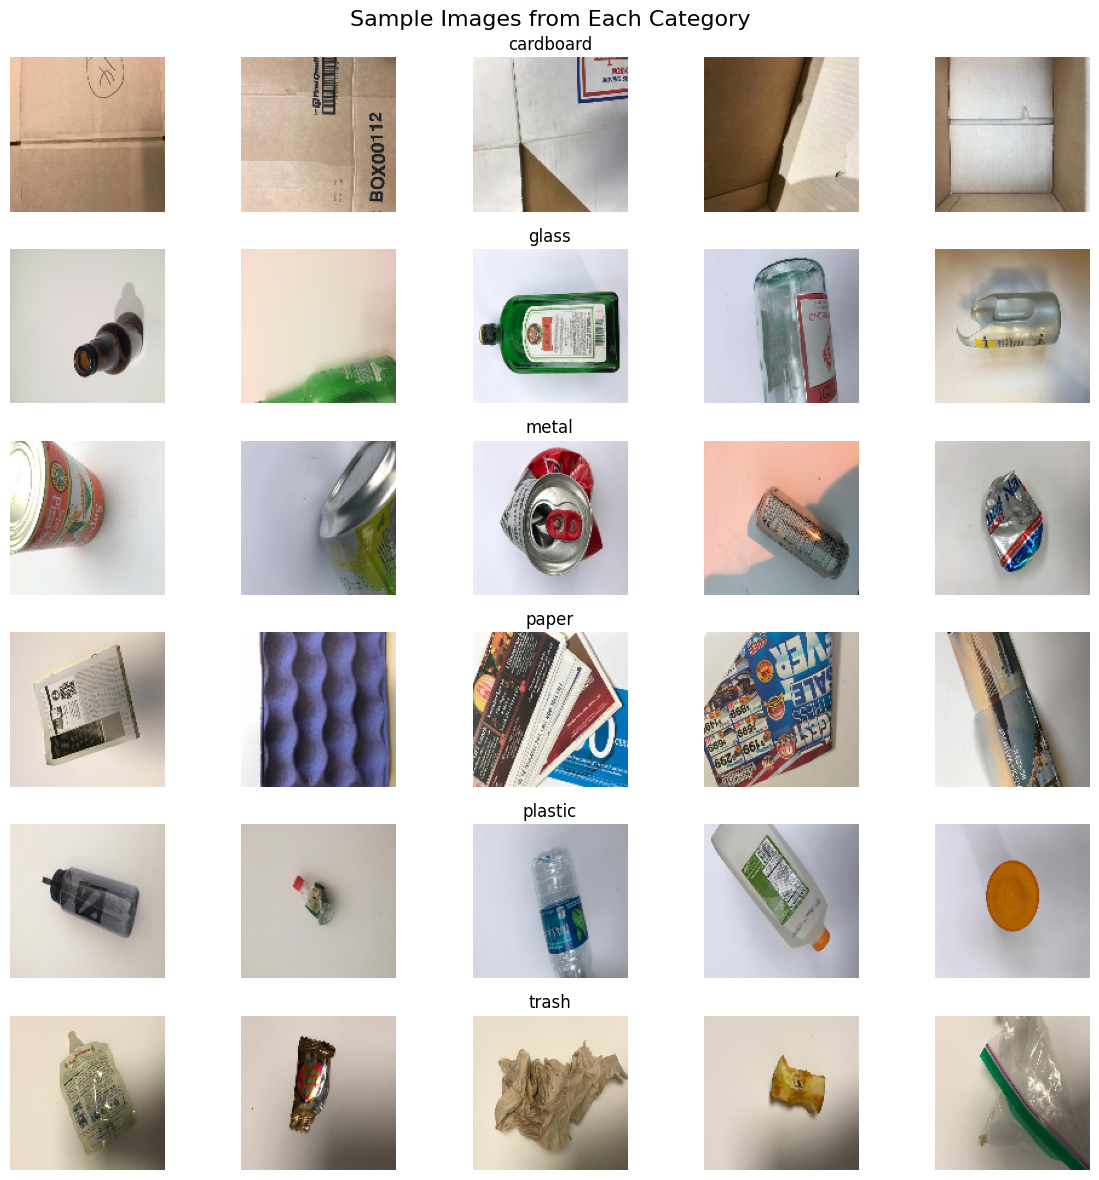

In [3]:
categories = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

n_sample = 5

fig, axes = plt.subplots(nrows=len(categories), ncols=n_sample, figsize=(12, 12))
fig.suptitle('Sample Images from Each Category', fontsize=16)

for i, category in enumerate(categories):
    category_dir = os.path.join(base_dir, category)
    images = os.listdir(category_dir)[:n_sample]
    for j, img in enumerate(images):
        img_path = os.path.join(category_dir, img)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(128, 128))
        axes[i, j].imshow(img)
        axes[i, j].axis('off')
        if j == 2:
            axes[i, j].set_title(category)

plt.tight_layout()
plt.show()

In [4]:
# With data augmentation
datagen = ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2,
    width_shift_range=0.1, 
    height_shift_range=0.1, 
    horizontal_flip=True
)

# # Without data augmentation
# datagen = ImageDataGenerator(
#     rescale=1./255, 
#     validation_split=0.2
# )


train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.


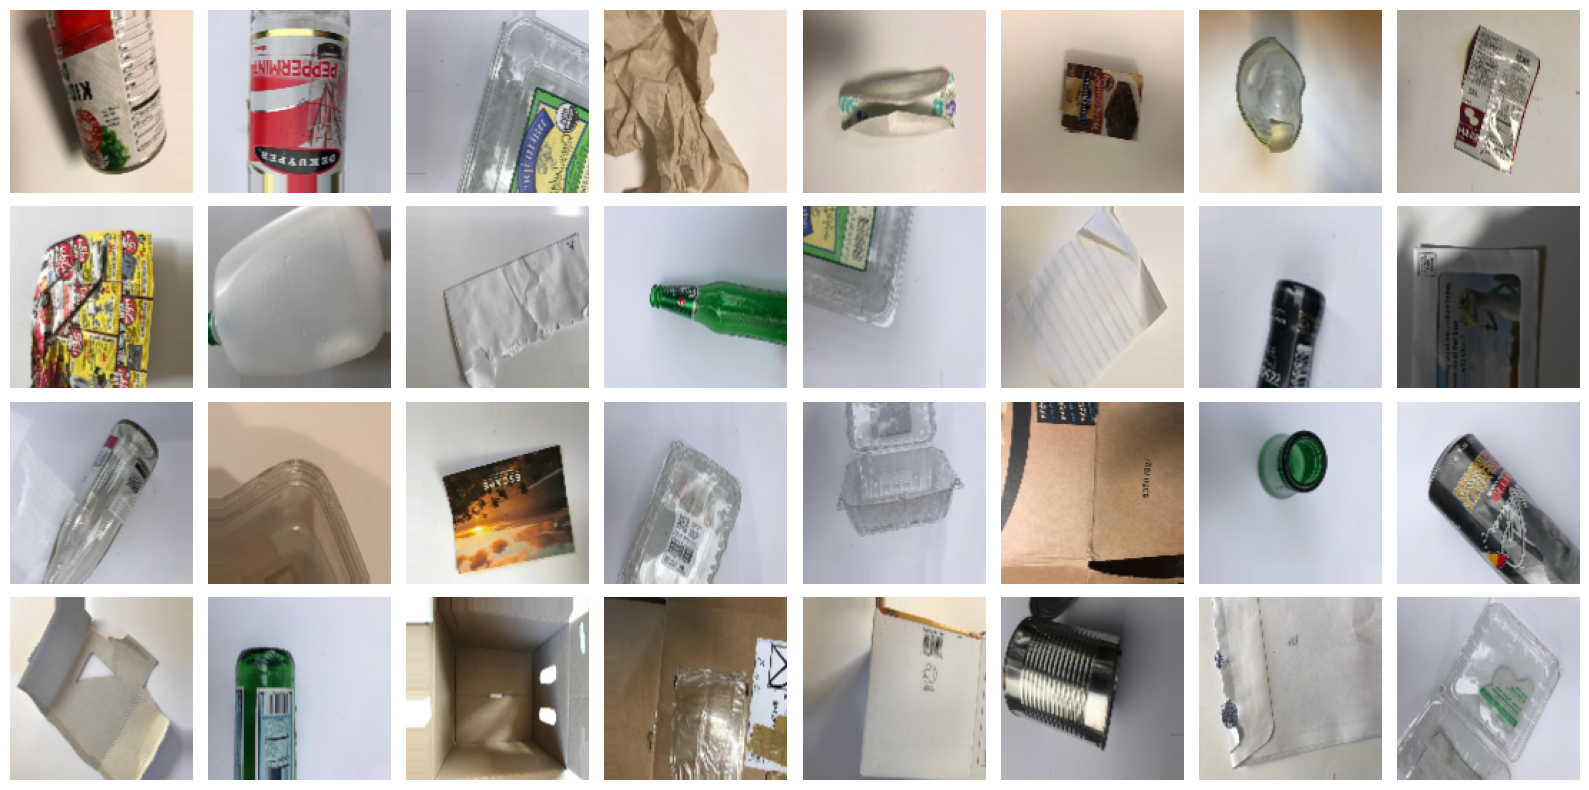

In [5]:
x_batch, y_batch = next(train_generator)

fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(16, 8))
for i in range(32):
    ax = axes[i // 8, i % 8]
    ax.imshow(x_batch[i])
    ax.axis('off')

plt.tight_layout()
plt.show()

Training set class distribution: 4579
Validation set class distribution: 1137


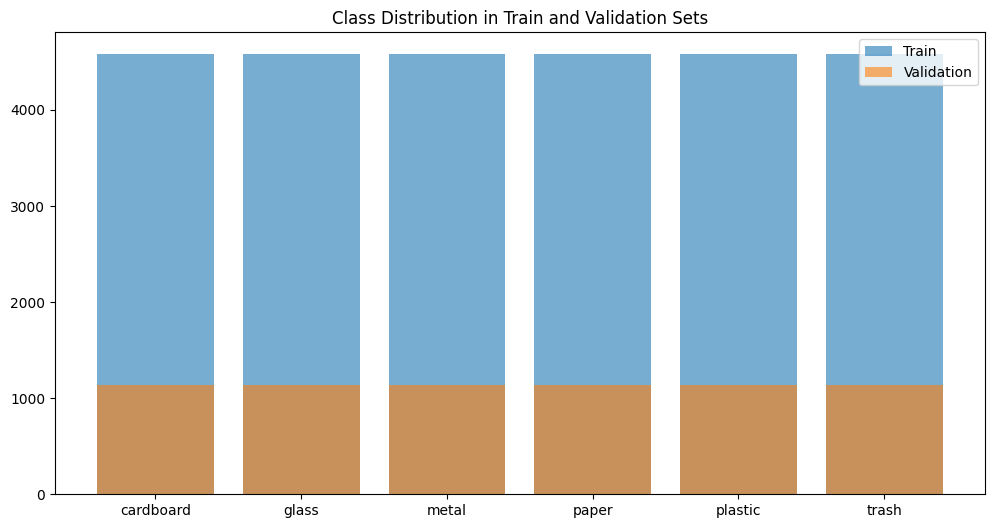

In [6]:
train_class_counts = np.sum(train_generator.labels, axis=0)
val_class_counts = np.sum(validation_generator.labels, axis=0)

print("Training set class distribution:", train_class_counts)
print("Validation set class distribution:", val_class_counts)

plt.figure(figsize=(12, 6))
plt.bar(categories, train_class_counts, alpha=0.6, label='Train')
plt.bar(categories, val_class_counts, alpha=0.6, label='Validation')
plt.legend()
plt.title('Class Distribution in Train and Validation Sets')
plt.show()

## Model Experimentation

In [7]:
n_class = len(train_generator.class_indices)
print(n_class)

6


In [8]:
i = Input(shape=(128, 128, 3))  # Update the input shape to match your data

# Convolutional Layers {Conv --> BatchNorm --> Conv --> BatchNorm --> MaxPooling (3x)}
x = Conv2D(32, (3,3), padding='same', activation='relu')(i)
x = BatchNormalization()(x)
x = Conv2D(32, (3,3), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Conv2D(64, (3,3), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3,3), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Conv2D(128, (3,3), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3,3), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2))(x)

# Neural Networks Layer
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(n_class, activation='softmax')(x)

model = Model(i, x)

In [9]:
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [10]:
train_generator.samples, train_generator.batch_size

(2024, 32)

In [11]:
validation_generator.samples, validation_generator.batch_size

(503, 32)

In [12]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=20  # Adjust the number of epochs based on your needs
)

Epoch 1/20


C:\Users\adven\anaconda3\envs\trash-classification\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.4467 - loss: 3.2675 - val_accuracy: 0.1917 - val_loss: 3.2705
Epoch 2/20
 1/63 ━━━━━━━━━━━━━━━━━━━━ 1:27 1s/step - accuracy: 0.6250 - loss: 1.3137

C:\Users\adven\anaconda3\envs\trash-classification\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6250 - loss: 1.3137 - val_accuracy: 0.2609 - val_loss: 3.0860
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.6544 - loss: 1.0580 - val_accuracy: 0.0854 - val_loss: 4.9419
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7188 - loss: 0.7069 - val_accuracy: 0.0435 - val_loss: 5.5177
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.7066 - loss: 0.7924 - val_accuracy: 0.1729 - val_loss: 4.8034
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7812 - loss: 0.7572 - val_accuracy: 0.2174 - val_loss: 5.1009
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.7559 - loss: 0.6759 - val_accuracy: 0.1958 - val_loss: 4.5812
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7812 - loss: 0.6642 - val_accuracy: 0.1304 - val_loss: 5.7588
Epoch 9/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.7534 - loss: 0.6757 - val_accuracy: 0.3104 - val_loss: 2.9063
Epo

In [15]:
# model.save('trash-classification.keras')
model.save('./models/trash-classification-aug.keras')

In [16]:
# model = load_model('trash-classification.keras')
model = load_model('./models/trash-classification-aug.keras')

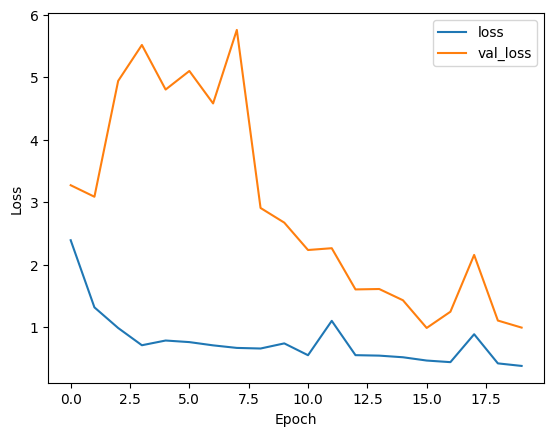

In [17]:
# Plot loss per iteration
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

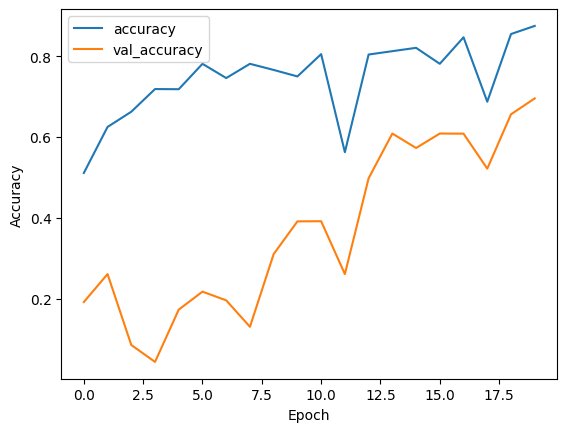

In [18]:
# Plot accuracy per iteration
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc=0)
plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 494ms/step


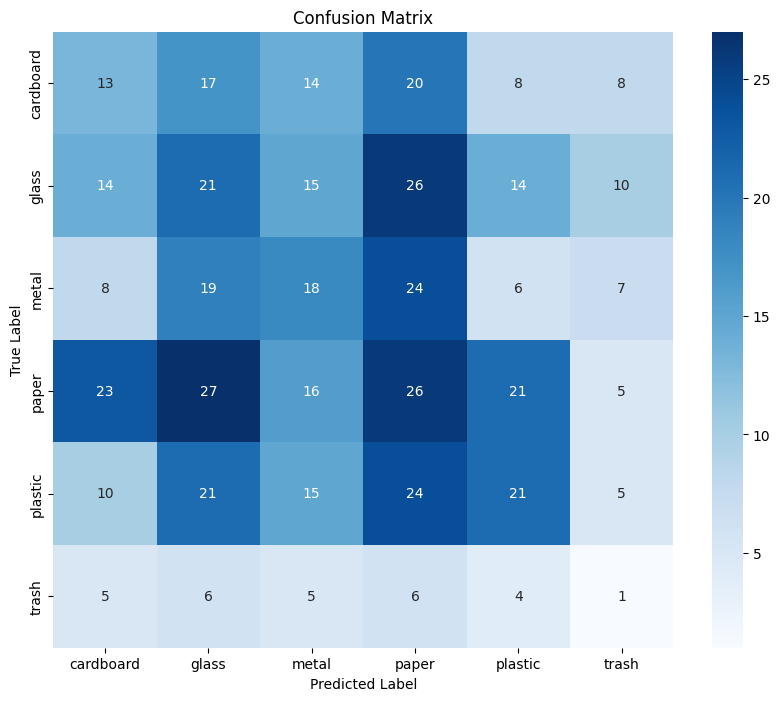

In [19]:
# Get true labels and predictions
validation_generator.reset()
Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = validation_generator.classes

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=validation_generator.class_indices.keys(), columns=validation_generator.class_indices.keys())

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [20]:
print('Classification Report')
target_names = list(validation_generator.class_indices.keys())
print(classification_report(y_true, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

   cardboard       0.18      0.16      0.17        80
       glass       0.19      0.21      0.20       100
       metal       0.22      0.22      0.22        82
       paper       0.21      0.22      0.21       118
     plastic       0.28      0.22      0.25        96
       trash       0.03      0.04      0.03        27

    accuracy                           0.20       503
   macro avg       0.18      0.18      0.18       503
weighted avg       0.21      0.20      0.20       503



16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 481ms/step


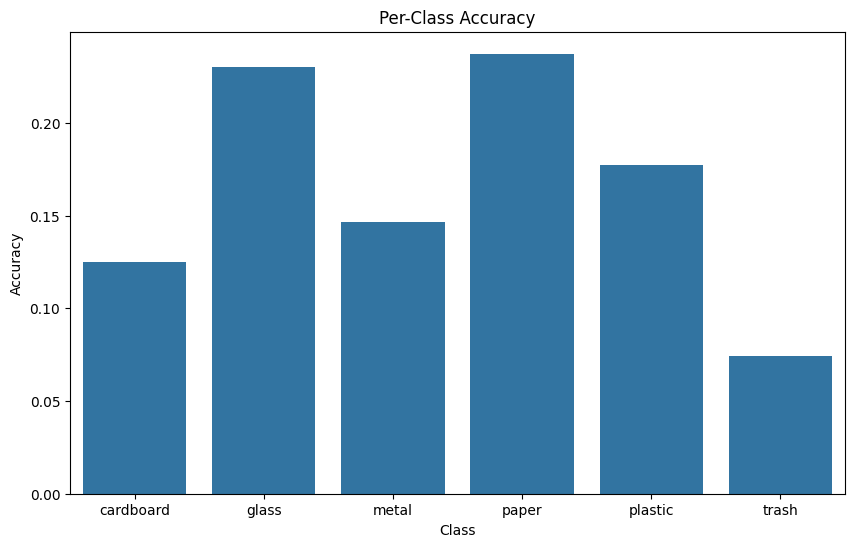

In [21]:
# Predict on validation set
validation_generator.reset()
Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = validation_generator.classes

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Normalize confusion matrix to get per-class accuracies
class_counts = np.sum(cm, axis=1)
class_accuracies = np.diagonal(cm) / class_counts

# Get class names
target_names = list(validation_generator.class_indices.keys())

# Plot per-class accuracies
plt.figure(figsize=(10, 6))
sns.barplot(x=target_names, y=class_accuracies)
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Per-Class Accuracy')
plt.show()